In [8]:

import warnings
warnings.filterwarnings('ignore')

import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo dos gráficos para uma melhor visualização
sns.set_theme(style="whitegrid")

# PySpark and Utils
try:
    sys.path.append(str(Path.cwd().parent / "src"))
    from pyspark.sql.functions import *
    from pyspark.sql.types import *
    import pyspark.sql.functions as F
    import matplotlib.pyplot as plt
    import seaborn as sns
    import math # Usado para math.fabs
    from utils import create_spark_session

    # T Learner
    from pyspark.ml.feature import Imputer

    # Imports do Scikit-Learn
    from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
    from sklearn.metrics import roc_auc_score
except ImportError as e:
    print(f"Import PySpark Error : {e}")    
    raise


In [9]:
# Criando Spark
spark = create_spark_session()

# Configuração de paths
project_root = Path.cwd().parent
data_raw_path = project_root / "data" / "raw"
data_processed_path = project_root / "data" / "processed"

print(f"project_root: {project_root}")
print(f"data_raw_path: {data_raw_path}")
print(f"data_processed_path: {data_processed_path}")

project_root: /Users/viniciusromano/vinicius/ifood-case
data_raw_path: /Users/viniciusromano/vinicius/ifood-case/data/raw
data_processed_path: /Users/viniciusromano/vinicius/ifood-case/data/processed


In [10]:
offers_df = spark.read.parquet(f"{data_processed_path}/offers_processed.parquet")


# Definição de features diferentes para diferentes modelos
- Preditivos com os base, além dos one hot encoded
- Inferência com mais features

In [11]:
outcome_col = 'offer_generated_transaction'

# Features para o modelo PREDITIVO
pred_features_base = [
    'time_since_test_start', 'age', 'credit_card_limit', 'days_since_registration',
    'discount_value', 'duration', 'min_value'
]
pred_features_one_hot = ['gender_F', 'gender_M', 'gender_O', 'channel_web', 'channel_email', 'channel_mobile', 'channel_social']
pred_features_sklearn = pred_features_base + pred_features_one_hot

# Features para o modelo CAUSAL
confounder_cols = pred_features_sklearn + [
    'cumulative_reward', 'reward_to_spend_ratio', 'cumulative_amount',
    'cumulative_transactions', 'cumulative_offer_driven_transactions',
    'cumulative_organic_transactions', 'cumulative_offers_received',
    'cumulative_offers_viewed', 'offer_streak_counter', 'organic_streak_counter'
]

Preparando dados para uma modelagem causal

In [12]:
df_causal = offers_df.filter(F.col('offer_type_informational') == 0) \
                       .withColumn("treatment", F.when(F.col('offer_type_discount') == 1, 1).otherwise(0))

imputer = Imputer(inputCols=confounder_cols, outputCols=confounder_cols, strategy="median")
df_imputed = imputer.fit(df_causal).transform(df_causal)

final_cols = [outcome_col, 'treatment'] + confounder_cols
df_sample = df_imputed.select(final_cols).sample(fraction=0.2, seed=42)
pd_sample = df_sample.toPandas()
print(f"--> Amostra de {len(pd_sample)} linhas coletada e pronta para as seções de modelagem.")

25/08/13 09:27:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


--> Amostra de 10259 linhas coletada e pronta para as seções de modelagem.


# Comparação de Modelos Preditivos (RandomForest vs. GBT)

- Separa os dados em variáveis de entrada e resultado.
- Treina um modelo **Random Forest** e mede sua performance (AUC-ROC).
- Treina um modelo **Gradient Boosting** e mede sua performance (AUC-ROC).
- Compara os dois resultados e escolhe o modelo com melhor desempenho.
- Salva no dataset final o **propensity score** calculado pelo modelo vencedor.

In [13]:
print("\n\n--- Comparação de Modelos Preditivos (RandomForest vs. GBT) ---")

W_pred_sample = pd_sample[pred_features_sklearn]
Y_full_sample = pd_sample[outcome_col]

# --- Treinando o RandomForest Preditivo ---
print("\n--> Treinando o Modelo 1: RandomForest...")
model_preditivo_rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=20, random_state=42)
model_preditivo_rf.fit(W_pred_sample, Y_full_sample)
propensity_scores_rf = model_preditivo_rf.predict(W_pred_sample)
auc_rf = roc_auc_score(Y_full_sample, propensity_scores_rf)
print(f"--> Performance do RandomForest (AUC-ROC): {auc_rf:.4f}")

# --- Treinando o GBT Preditivo ---
print("\n--> Treinando o Modelo 2: Gradient Boosting (GBT)...")
gbr_params_preditivo = {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 20, 'subsample': 0.8}
model_preditivo_gbt = GradientBoostingRegressor(**gbr_params_preditivo, random_state=42)
model_preditivo_gbt.fit(W_pred_sample, Y_full_sample)
propensity_scores_gbt = model_preditivo_gbt.predict(W_pred_sample)
auc_gbt = roc_auc_score(Y_full_sample, propensity_scores_gbt)
print(f"--> Performance do GBT (AUC-ROC): {auc_gbt:.4f}")

print("\n--> Comparando performances e selecionando o vencedor...")
if auc_gbt > auc_rf:
    vencedor_nome = "Gradient Boosting (GBT)"
    vencedor_auc = auc_gbt
    propensity_scores = propensity_scores_gbt
    print(f"*** VENCEDOR: {vencedor_nome} com AUC-ROC de {vencedor_auc:.4f} ***")
else:
    vencedor_nome = "Random Forest"
    vencedor_auc = auc_rf
    propensity_scores = propensity_scores_rf
    print(f"*** VENCEDOR: {vencedor_nome} com AUC-ROC de {vencedor_auc:.4f} ***")

pd_sample['propensity_score'] = propensity_scores



--- Comparação de Modelos Preditivos (RandomForest vs. GBT) ---

--> Treinando o Modelo 1: RandomForest...
--> Performance do RandomForest (AUC-ROC): 0.8006

--> Treinando o Modelo 2: Gradient Boosting (GBT)...
--> Performance do GBT (AUC-ROC): 0.8825

--> Comparando performances e selecionando o vencedor...
*** VENCEDOR: Gradient Boosting (GBT) com AUC-ROC de 0.8825 ***


Treinamento do modelo causal (T-LEARNER)

In [16]:
print("\n\n---Treinando o Modelo Causal (T-Learner) para obter o Uplift ---")
# O T-Learner agora roda de forma independente para gerar o score de uplift
pd_treated = pd_sample[pd_sample['treatment'] == 1]
pd_control = pd_sample[pd_sample['treatment'] == 0]
Y_treated = pd_treated[outcome_col]; W_treated = pd_treated[confounder_cols]
Y_control = pd_control[outcome_col]; W_control = pd_control[confounder_cols]
gbr_params_causal = {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 20}
model_treated = GradientBoostingRegressor(**gbr_params_causal, random_state=42)
model_control = GradientBoostingRegressor(**gbr_params_causal, random_state=42)
model_treated.fit(W_treated, Y_treated)
model_control.fit(W_control, Y_control)

W_full_sample = pd_sample[confounder_cols]
predictions_if_treated = model_treated.predict(W_full_sample)
predictions_if_control = model_control.predict(W_full_sample)
uplift_scores = predictions_if_treated - predictions_if_control
pd_sample['uplift_score'] = uplift_scores
print("--> Scores de Uplift calculados com sucesso.")



---Treinando o Modelo Causal (T-Learner) para obter o Uplift ---
--> Scores de Uplift calculados com sucesso.


In [17]:
print("\n--- Gerando análise estratégica e resumo final ---")
# --- Análise de Quadrantes ---
propensity_threshold = pd_sample['propensity_score'].median()
uplift_threshold = 0.01

quadrante = []
for index, row in pd_sample.iterrows():
    if row['propensity_score'] >= propensity_threshold and row['uplift_score'] > uplift_threshold:
        quadrante.append('Persuadíveis')
    elif row['propensity_score'] >= propensity_threshold and row['uplift_score'] <= uplift_threshold:
        quadrante.append('Certezas')
    elif row['propensity_score'] < propensity_threshold and row['uplift_score'] > uplift_threshold:
        quadrante.append('Adormecidos')
    else:
        quadrante.append('Casos Perdidos')
pd_sample['quadrante'] = quadrante

quadrante_counts = pd_sample['quadrante'].value_counts(normalize=True) * 100


--- Gerando análise estratégica e resumo final ---


Geração de um gráfico para observar melhor os quadrantes


--> Gerando o gráfico dos quadrantes estratégicos...


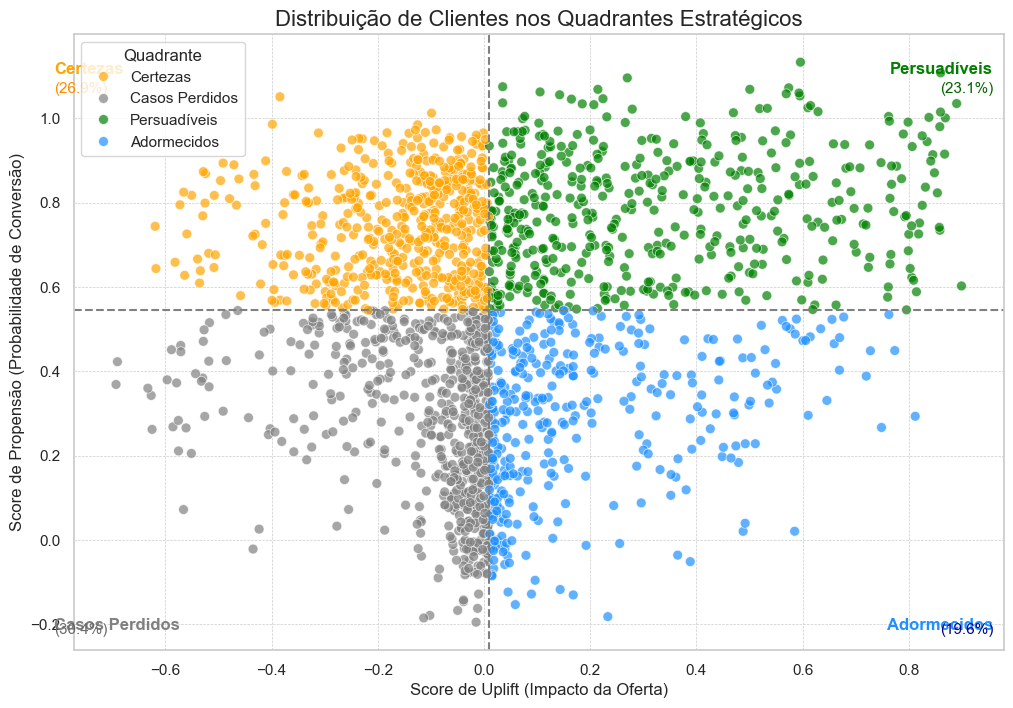

In [18]:
print("\n--> Gerando o gráfico dos quadrantes estratégicos...")
plt.figure(figsize=(12, 8))
viz_sample = pd_sample.sample(n=__builtins__.min(2000, len(pd_sample)), random_state=42)
sns.scatterplot(data=viz_sample, x='uplift_score', y='propensity_score', hue='quadrante', palette={'Persuadíveis': 'green', 'Certezas': 'orange', 'Adormecidos': 'dodgerblue', 'Casos Perdidos': 'grey'}, alpha=0.7, s=50)
plt.axvline(x=uplift_threshold, color='grey', linestyle='--'); plt.axhline(y=propensity_threshold, color='grey', linestyle='--')
plt.title('Distribuição de Clientes nos Quadrantes Estratégicos', fontsize=16)
plt.xlabel('Score de Uplift (Impacto da Oferta)', fontsize=12); plt.ylabel('Score de Propensão (Probabilidade de Conversão)', fontsize=12)
plt.text(pd_sample['uplift_score'].max(), pd_sample['propensity_score'].max(), 'Persuadíveis', ha='right', va='top', fontsize=12, weight='bold', color='green')
plt.text(pd_sample['uplift_score'].max(), pd_sample['propensity_score'].max() * 0.96, f"({quadrante_counts.get('Persuadíveis', 0):.1f}%)", ha='right', va='top', fontsize=11, color='darkgreen')
plt.text(pd_sample['uplift_score'].min(), pd_sample['propensity_score'].max(), 'Certezas', ha='left', va='top', fontsize=12, weight='bold', color='orange')
plt.text(pd_sample['uplift_score'].min(), pd_sample['propensity_score'].max() * 0.96, f"({quadrante_counts.get('Certezas', 0):.1f}%)", ha='left', va='top', fontsize=11, color='darkorange')
plt.text(pd_sample['uplift_score'].max(), pd_sample['propensity_score'].min(), 'Adormecidos', ha='right', va='bottom', fontsize=12, weight='bold', color='dodgerblue')
plt.text(pd_sample['uplift_score'].max(), pd_sample['propensity_score'].min() * 1.04, f"({quadrante_counts.get('Adormecidos', 0):.1f}%)", ha='right', va='bottom', fontsize=11, color='darkblue')
plt.text(pd_sample['uplift_score'].min(), pd_sample['propensity_score'].min(), 'Casos Perdidos', ha='left', va='bottom', fontsize=12, weight='bold', color='grey')
plt.text(pd_sample['uplift_score'].min(), pd_sample['propensity_score'].min() * 1.04, f"({quadrante_counts.get('Casos Perdidos', 0):.1f}%)", ha='left', va='bottom', fontsize=11, color='dimgrey')
plt.legend(title='Quadrante'); plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [19]:
# --- Geração do Resumo Final ---
TICKET_MEDIO = 12.77; MARGEM_LUCRO = 0.08
ate_estimado = pd_sample['uplift_score'].mean()
persuadiveis_df = pd_sample[pd_sample['quadrante'] == 'Persuadíveis']
certezas_df = pd_sample[pd_sample['quadrante'] == 'Certezas']
uplift_persuadiveis = persuadiveis_df['uplift_score'].mean() if not persuadiveis_df.empty else 0
uplift_certezas = certezas_df['uplift_score'].mean() if not certezas_df.empty else 0
tamanho_persuadiveis = len(persuadiveis_df); tamanho_certezas = len(certezas_df)
total_sample = len(pd_sample)
lucro_por_conversao = TICKET_MEDIO * MARGEM_LUCRO
roi_estrategia_persuadiveis = (tamanho_persuadiveis * uplift_persuadiveis * lucro_por_conversao)
roi_desperdicado_certezas = math.fabs(tamanho_certezas * uplift_certezas * lucro_por_conversao)
total_valor_gerado = roi_estrategia_persuadiveis + roi_desperdicado_certezas
ganho_por_1000_clientes = (roi_estrategia_persuadiveis / total_sample) * 1000 if total_sample > 0 else 0


print("\n\n\n---============================================================---")
print("---        RESUMO ESTRATÉGICO PARA TOMADA DE DECISÃO         ---")
print("---============================================================---")

print(f"\n[MÉTRICAS DO MODELO PREDITIVO (Vencedor: {vencedor_nome})]")
print(f"[*] AUC-ROC do Modelo Preditivo: {vencedor_auc:.4f}")
print(f"    -> O que significa: Este modelo tem uma capacidade de {vencedor_auc:.2%} de distinguir um cliente que converte de um que não converte.")
print(f"    -> Como ele ajudou: Ele nos deu o 'score de propensão', que é a base para nossa matriz estratégica.")

print("\n[MÉTRICAS DO MODELO CAUSAL (T-Learner)]")
print(f"[*] Efeito Médio do Tratamento (ATE) estimado: {ate_estimado:.2%}")
print(f"    -> O que significa: Em média, a oferta de 'Desconto' aumenta a probabilidade de conversão em {ate_estimado:.2%} em comparação com a oferta 'BOGO'.")

print("\n[ANÁLISE DOS QUADRANTES ESTRATÉGICOS]")
print(f"Amostra total analisada: {total_sample} clientes.")
print("-" * 50)
print(f"** 1. Quadrante 'Persuadíveis' (Alvo Principal) **")
print(f"   - Composição da base: {quadrante_counts.get('Persuadíveis', 0):.1f}%")
print(f"   - Uplift Médio deste grupo: {uplift_persuadiveis:.2%}")
print(f"   - Ação Recomendada: DIRECIONAR OFERTA. Este é o grupo com maior potencial de ROI.")
print(f"\n** 2. Quadrante 'Certezas' (Risco de Desperdício) **")
print(f"   - Composição da base: {quadrante_counts.get('Certezas', 0):.1f}%")
print(f"   - Uplift Médio deste grupo: {uplift_certezas:.2%}")
print(f"   - Ação Recomendada: NÃO ENVIAR OFERTA. Estes clientes comprariam de qualquer forma.")
print(f"\n** 3. Quadrante 'Adormecidos' (Potencial de Expansão) **")
print(f"   - Composição da base: {quadrante_counts.get('Adormecidos', 0):.1f}%")
print(f"   - Ação Recomendada: Analisar Custo vs. Benefício.")
print(f"\n** 4. Quadrante 'Casos Perdidos' (Ignorar) **")
print(f"   - Composição da base: {quadrante_counts.get('Casos Perdidos', 0):.1f}%")
print(f"   - Ação Recomendada: NÃO ENVIAR OFERTA.")

print("\n[SIMULAÇÃO DE IMPACTO FINANCEIRO E ROI]")
print(f"Considerando um Ticket Médio de R${TICKET_MEDIO:.2f} e Margem de Lucro de {MARGEM_LUCRO:.0%}.")
print("-" * 50)
print(f"[*] Foco nos 'Persuadíveis': Ao direcionar a oferta apenas para este grupo, o ganho incremental estimado para cada {total_sample} clientes na amostra é de R${roi_estrategia_persuadiveis:.2f}.")
print(f"[*] Desperdício Evitado: Ao não enviar a oferta para as 'Certezas', você evita canibalizar aproximadamente R${roi_desperdicado_certezas:.2f} em lucro para cada {total_sample} clientes na amostra.")
print(f"\n[+] Valor Total Gerado pela Estratégia: O valor combinado de ganhos incrementais e economia resulta em um impacto positivo total de R${total_valor_gerado:.2f} para a amostra analisada.")
print(f"[*] Extrapolação de Lucro: Para cada 1000 clientes direcionados com esta estratégia, o modelo pode aumentar os lucros em aproximadamente R${ganho_por_1000_clientes:.2f}.")
print(f"\nConclusão de ROI: A estratégia de direcionamento por uplift não só gera lucro incremental, como também protege a margem ao evitar descontos desnecessários, otimizando significativamente o retorno sobre o investimento da campanha.")




---============================================================---
---        RESUMO ESTRATÉGICO PARA TOMADA DE DECISÃO         ---
---============================================================---

[MÉTRICAS DO MODELO PREDITIVO (Vencedor: Gradient Boosting (GBT))]
[*] AUC-ROC do Modelo Preditivo: 0.8825
    -> O que significa: Este modelo tem uma capacidade de 88.25% de distinguir um cliente que converte de um que não converte.
    -> Como ele ajudou: Ele nos deu o 'score de propensão', que é a base para nossa matriz estratégica.

[MÉTRICAS DO MODELO CAUSAL (T-Learner)]
[*] Efeito Médio do Tratamento (ATE) estimado: 3.82%
    -> O que significa: Em média, a oferta de 'Desconto' aumenta a probabilidade de conversão em 3.82% em comparação com a oferta 'BOGO'.

[ANÁLISE DOS QUADRANTES ESTRATÉGICOS]
Amostra total analisada: 10259 clientes.
--------------------------------------------------
** 1. Quadrante 'Persuadíveis' (Alvo Principal) **
   - Composição da base: 23.1%
   - Uplift Mé

Para os Persuadíveis (23.1% da base): "Nossa análise combinada provou que, para este grupo, a oferta de 'Desconto' é a mais eficaz. Ela aumenta a probabilidade de conversão em 33 pontos percentuais em comparação com a oferta 'BOGO', gerando o maior retorno sobre o investimento e um lucro incremental estimado de R$1017 para cada 10.259 clientes."

Para as Certezas (26.9% da base): "Identificamos um grande grupo de clientes para quem a oferta de 'Desconto' é, na verdade, prejudicial, diminuindo a chance de conversão em 16 pontos percentuais em relação à oferta 'BOGO'. Ao evitar dar o Desconto para este grupo, nós não só paramos de usar uma tática ineficaz, como também economizamos R$577 em lucro que seria desperdiçado."


Nossa análise revelou que, embora a oferta de 'Desconto' seja, em média, 3.82 pontos percentuais mais eficaz que a de 'BOGO', uma estratégia de massa seria ineficiente. Ao combinar um modelo preditivo com uma análise causal, desenvolvemos uma abordagem cirúrgica: identificamos um grupo de 'Persuadíveis' (23% da base) para quem a oferta de Desconto aumenta a chance de conversão em massivos 33%. Ao focar nossa campanha exclusivamente neste grupo e evitar as 'Certezas' (para quem a oferta era prejudicial), o impacto efetivo da nossa estratégia sobe de 3.82% para cerca de 7.6%, quase dobrando a eficiência da campanha e gerando um ROI significativamente maior, como demonstrado na simulação financeira.